In [1]:
import numpy as np

import sys
sys.path.append('../qslam/')
from visualiserisk import DataCube

from visualiserisk import *
from qslamdesignparams import GRIDDICT

In [5]:
msmt_per_qubit_scan = [1] 
meta_max_iter_scan = [ 1, 2, 3, 4, 6, 12, 18, 24, 30, 60, 72, 96, 120, 246]
lambda_databse = np.load('./lambda_pairs_2.npz')
lambda1 = list(lambda_databse['lambda_1']) 
lambda2 = list(lambda_databse['lambda_2']) 

lambda_scan = zip(lambda1, lambda2)

LOOPS_DICT = {"meta_max_iter_scan":meta_max_iter_scan, 
              "lambda_scan":lambda_scan,
              "msmt_per_qubit_scan": msmt_per_qubit_scan}

ParamUpdater = DataCube(LOOPS_DICT)

max_msmt_var = len(meta_max_iter_scan)
max_lambda_var_= len(lambda_scan) #32, 68, 95 is good but not as good as in paper 1. 
data_key_list = range(1, 2, 1) # range(1, 5, 1) Only CE Ramsey data analysed

THRESHOLD = 0.025 # same as simulations
max_cases = len(data_key_list)


# Interpolation 
start_iter=0
end_iter=max_msmt_var

# Fixed Lambda
opt_lambda_at_iteration = 7

# Maps, Optimisatio Curves
pick_msmt_regimes = [7, 11]
pick_msmt_regimes_maps = [4, 11]

# Final plot range
maxssim = 0.6
min_sims = [0.05]*4

In [6]:
def get_ssim_data(data_key, idx_msmt_var, max_lambda_var=50):
    
    full_data_matrix = np.load('2019_Jun_qslam_exptdata_'+str(data_key)+'.npz')['meta_ssim_pairs'] 
    qslamdata = full_data_matrix[0: max_lambda_var, 0 , idx_msmt_var] #qslam is the first index
    naivedata = full_data_matrix[0: max_lambda_var, 1 , idx_msmt_var]
    index_array = np.argsort(qslamdata)
    
    return qslamdata, index_array, naivedata


def extract_optimal_cases(max_msmt_var, max_lambda_var=50):
    
#     data_key_list = range(1, 5, 1)
#     max_cases = len(data_key_list)
    
    optimal_matrix = np.zeros((max_cases, max_msmt_var, 3))
    naive_matrix = np.zeros((max_cases, max_msmt_var, 2))
    optimal_cases = np.zeros((max_cases, max_msmt_var, max_lambda_var))
    
    for idx_msmt_var in range(max_msmt_var):
        
        for idx_truth in range(max_cases):
            
            data_key = data_key_list[idx_truth]
            
            a, index_array, naive = get_ssim_data(data_key, idx_msmt_var, 
                                                  max_lambda_var=max_lambda_var)


            optimal_matrix[idx_truth, idx_msmt_var, 0] = a[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 1] = lambda1[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 2] = lambda2[index_array[0]]

            naive_matrix[idx_truth, idx_msmt_var, 0] = np.mean(naive)
            naive_matrix[idx_truth, idx_msmt_var, 1] = np.std(naive)
            
            truncate = len(index_array)           
            optimal_cases[idx_truth, idx_msmt_var, :truncate] = index_array
    
    return optimal_matrix, naive_matrix, optimal_cases

Pick Msmt regimes 7
with total msmts 24
Pick Msmt regimes 11
with total msmts 96


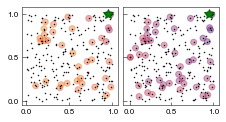

In [8]:
# Choose colormap
cmap = plt.cm.inferno
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.ones(cmap.N)*0.4
# Create new colormap
my_cmap = ListedColormap(my_cmap)

optimal_matrix, naive_matrix, optimal_cases = extract_optimal_cases(max_msmt_var, max_lambda_var=max_lambda_var_)

gslayout = gs(3, 2 , top = 0.95, bottom =0.05, left = 0.1, right = 0.9, wspace = 0.05, hspace = 0.05)

fig = plt.figure(figsize=(cm2inch(8.7),cm2inch(12)))

for truth in range(len(data_key_list)):
       
    for idx_opt in range(len(pick_msmt_regimes)):
    
        filename = data_key_list[truth]
        a, index_array, naive = get_ssim_data(filename, pick_msmt_regimes[idx_opt])
        
        print "Pick Msmt regimes", pick_msmt_regimes[idx_opt]
        print "with total msmts", meta_max_iter_scan[pick_msmt_regimes[idx_opt]]
        ax = fig.add_subplot(gslayout[truth, idx_opt ])
        ax.plot(lambda1[0:max_lambda_var_], lambda2[0:max_lambda_var_], 'ko', ms=0.5, alpha=1)
              
        optimal_color = 'green'
        diff = a[0] - a[index_array[0]]  
        if diff < 0 :
            optimal_color = 'g'
        elif diff >=0 :
            if diff < THRESHOLD: 
                optimal_color = 'g'



        better_than_control=[]
        for idx_l in index_array:
            diff = a[0] - a[idx_l] 

            if diff < 0 :
                break
            elif diff >=0 :
                if diff < THRESHOLD: 
                    break
            if idx_l == 0:
                break
            better_than_control.append(idx_l)
        
        red_values = np.take(a, better_than_control)
        im = ax.scatter(np.take(lambda1, better_than_control), 
                   np.take(lambda2, better_than_control),
                   c= red_values,
                   vmin=0.0, vmax=1.0, 
                   cmap= my_cmap)
        
        ax.plot(lambda1[index_array[0]],lambda2[index_array[0]], '*', markeredgecolor='darkgreen',
                c=optimal_color, ms=10, alpha=1.)
        
        if idx_opt >0:
            ax.get_yaxis().set_ticklabels([])
#         if truth < 2:
#             ax.get_xaxis().set_ticklabels([])
        
        # Want square graphs with same number of ticks
        # ax.set_aspect(1.)
        equaltics = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(equaltics)
        ax.yaxis.set_major_locator(equaltics)
        # ax.set(xlabel=r'$\lambda_i $', ylabel=r'$\lambda_j$')
        # ax.set_title(str(ParamUpdater.meta_max_iter_scan[pick_msmt_regimes[idx_opt]])+', '+str(np.round(a[index_array[0]] / a[0], 3)))
        
# plt.colorbar(im, ticks=[0.0, 0.7], format='%0.2f', orientation='horizontal')
plt.savefig('../paperfigs/expt_opt_v3.svg', format='svg', dpi=800)
plt.show()

# Interpolation and Msmt Analysis

In [9]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

1


/home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


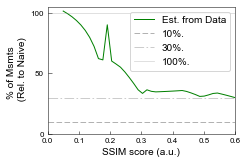

In [10]:
''' Save optimal_inverse_curves_list and use it in the next Workbook cell.
'''


algolabel = ['qslam', 'naive']
ssim_c = ['indigo', 'firebrick']
metrictypename='ssim'

gslayout = gs(1, 1, top = 0.95, bottom =0.05, left = 0.12, right = 0.88, wspace = 0.4, hspace = 0.4)

optimal_inverse_curves_list = []
for idx_truth in range(max_cases):


    data_key = data_key_list[idx_truth]
    print data_key
    pickl = [optimal_cases[idx_truth, idx, 0] for idx in range(max_msmt_var)]
    
    full_data_matrix = np.load('2019_Jun_qslam_exptdata_'+str(data_key)+'.npz')['meta_ssim_pairs']
    
    qslam_data = [full_data_matrix[pickl[idx], 0, idx] for idx in range(max_msmt_var)]
    naive_data = [full_data_matrix[pickl[idx], 1, idx] for idx in range(max_msmt_var)]
    
    # Extrapolation range depends on the type of experiment
    ssim_vals = np.linspace(min_sims[idx_truth], maxssim, 40)
    
    # Interpolation 1D linear
    msmts = ParamUpdater.meta_max_iter_scan[start_iter: end_iter]
    qslam_invfunc = interp1d(qslam_data[start_iter: end_iter], msmts, fill_value='extrapolate')
    naive_invfunc = interp1d(naive_data[start_iter: end_iter], msmts, fill_value='extrapolate')

    ratio_extrapolated = qslam_invfunc(ssim_vals) / naive_invfunc(ssim_vals)

    ydata = [qslam_data, naive_data]
    interpy = {algolabel[0]: qslam_invfunc, algolabel[1]: naive_invfunc}
        
    # ---PLOT INVERSE FIGURE -----------------------------------------------------------------------------
    
    fig = plt.figure(figsize=(cm2inch(8.7),cm2inch(5)))

    ax = fig.add_subplot(gslayout[0,0])
    
    ax.plot(ssim_vals, ratio_extrapolated*100.0, '-', ms=1.5, lw=1.0, c='green', label="Est. from Data")
    ax.set_xlim([0.0, maxssim])
    ax.set_yticks(np.arange(0,1.25,0.5)*100.0)
    
    ax.axhline(y=10, ls='--', label='10%.', c='grey', alpha = 0.75, lw=0.8)
    ax.axhline(y=30, ls='-.', label='30%.', c='grey', alpha = 0.5, lw=0.8)
    ax.axhline(y=100, ls='-', label='100%.', c='grey', alpha = 0.3, lw=0.8)
 
    ax.set_xlabel('SSIM score (a.u.)')
    ax.set_ylabel('% of Msmts \n (Rel. to Naive)')
    ax.legend(loc=0)
    
    optimal_inverse_curves_list.append([ssim_vals, ratio_extrapolated])
        
    plt.savefig('../paperfigs/'+metrictypename+str(idx_truth)+'expt_opt_inv_v3.svg', format='svg', dpi=800)
    plt.show()

Truth 0
Fixed value case:
lambda 1 0.949724918298
lambda 2 0.997703630851


/home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/riddhisw/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


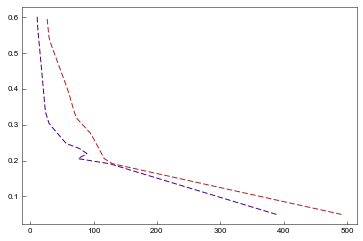

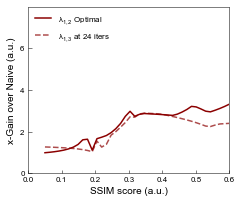

In [11]:
'''Add the fully optimised inverse curves '''

algolabel = ['qslam', 'naive']
ssim_c = ['indigo', 'firebrick']

gslayout = gs(1, 1, top = 0.99, bottom =0.15, left = 0.125, right = 0.95, wspace = 0.01, hspace = 0.01)

for idx_truth in range(max_cases):

    pick_lambda_idx = optimal_cases[idx_truth, opt_lambda_at_iteration, 0]
    
    data_key = data_key_list[idx_truth]
    full_data_matrix = np.load('2019_Jun_qslam_exptdata_'+str(data_key)+'.npz')['meta_ssim_pairs']
    
    print 'Truth', idx_truth
    print 'Fixed value case:'
    print 'lambda 1', lambda1[int(pick_lambda_idx)]
    print 'lambda 2', lambda2[int(pick_lambda_idx)]
    
    qslam_data = full_data_matrix[pick_lambda_idx, 0, :]
    naive_data = full_data_matrix[pick_lambda_idx, 1, :]
    
    # Extrapolation range depends on the type of experiment
    ssim_vals = np.linspace(min_sims[idx_truth], maxssim, 40)
    
    # Interpolation 1D linear
    msmts = ParamUpdater.meta_max_iter_scan[start_iter: end_iter]
    qslam_invfunc = interp1d(qslam_data[start_iter: end_iter], msmts, fill_value='extrapolate')
    naive_invfunc = interp1d(naive_data[start_iter: end_iter], msmts, fill_value='extrapolate')

#     # Interpolation Univariate Spline
#     qidx = np.argsort(qslam_data)
#     nidx = np.argsort(naive_data)
#     msmts = ParamUpdater.meta_max_iter_scan[start_iter:]
#     qslam_invfunc = UnivariateSpline(np.take(qslam_data, qidx), np.take(msmts, qidx), k=1)#, fill_value='extrapolate')
#     naive_invfunc = UnivariateSpline(np.take(naive_data, nidx),  np.take(msmts, nidx), k=1)#, fill_value='extrapolate')

    ratio_extrapolated = qslam_invfunc(ssim_vals) / naive_invfunc(ssim_vals)

    ydata = [qslam_data, naive_data]
    interpy = {algolabel[0]: qslam_invfunc, algolabel[1]: naive_invfunc}


    # -------CHECK INTERPOLATION BEFORE INVERTING IT ------------------------------------------
    plt.figure()
    ax = plt.subplot(111)
    for algo in range(2):
        ax.plot(interpy[algolabel[algo]](ssim_vals), ssim_vals, '--',  
                label = algolabel[algo],
                alpha = 1.0,
                color = ssim_c[algo],
                ms=1.5,
                lw=1.)

    plt.show()
    # ------------------------------------------------------------------------------------------
        
    # ---PLOT INVERSE FIGURE -----------------------------------------------------------------------------
    
    fig = plt.figure(figsize=(cm2inch(8.6),cm2inch(7)))
    ax = fig.add_subplot(gslayout[0,0])
    
    # ---- Add optimised curve here ---
    
    ax.plot(optimal_inverse_curves_list[idx_truth][0], 1./ optimal_inverse_curves_list[idx_truth][1],
           '-', ms=1.5, lw=1.5, alpha=1,c='darkred', label=r'$\lambda_{1,2}$ Optimal')
    
    # ---- Add a fixed lambda curve here ---
    ax.plot(ssim_vals, 1./ ratio_extrapolated, 
            '--', ms=1.5, lw=1.5, alpha=0.7, c='darkred', label=r'$\lambda_{1,3}$ at $%s$ iters' %(msmts[opt_lambda_at_iteration]))
    
    
    ax.set_xlim([0.0, maxssim])
    ax.set_yticks(np.arange(0, 8, 2))
    ax.set_ylim([0, 8])
 
    ax.set_xlabel('SSIM score (a.u.)')
    ax.set_ylabel('x-Gain over Naive (a.u.)')
    ax.legend(loc=2, fontsize=8, frameon=False)
        
    plt.savefig('../paperfigs/'+metrictypename+str(idx_truth)+'expt_inv_v3.svg', format='svg', dpi=800)
    plt.show()

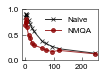

In [12]:
optimal_matrix, naive_matrix, optimal_cases = extract_optimal_cases(max_msmt_var, 
                                                                    max_lambda_var=max_lambda_var_,
                                                                    )

gslayout = gs(1,1 , top = 0.9, bottom =0.3, left = 0.3, right = 0.9, wspace = 0.01, hspace = 0.01)

for truth in range(len(data_key_list)):
    
    fig = plt.figure(figsize=(cm2inch(4.5),cm2inch(3.)))
    
    ax1 = fig.add_subplot(gslayout[0, 0])
    
    ax1.plot(ParamUpdater.meta_max_iter_scan, naive_matrix[truth, :, 0], label='Naive',
            markerfacecolor='white', markeredgecolor='k', color='k', alpha=0.8,
            markeredgewidth=0.8, marker='x', linestyle='-', lw=1., ms=4)
    ax1.plot(ParamUpdater.meta_max_iter_scan, optimal_matrix[truth, :, 0], label='NMQA',
            markerfacecolor='darkred', markeredgecolor='darkred', color='darkred', alpha=0.8,
            markeredgewidth=0.8, marker='o', linestyle='-', lw=1., ms=4)

    ax1.set_ylim([0, 1])
    plt.legend(loc=0, fontsize=8, frameon=False)
    
    #----------------------------------------------------------------------------------------------------
    plt.savefig('../paperfigs/'+metrictypename+str(truth)+'expt_inset_v3.svg', format='svg', dpi=800)
    plt.show()
    

In [13]:
data_key = 1

num_qubits_list = [6, 6, 5, 5]
num_qubits = num_qubits_list[data_key - 1]
from qslamdesignparams import GRIDDICT, GLOBALDICT
from exptrisk import EmpiricalRisk
import copy

In [14]:
change_MAX_NUM_ITERATIONS = 5
change_MSMTS_PER_NODE = 1
change_SIGMOID_APPROX_ERROR = 10.0**(-6)
change_QUANTISATION_UNCERTY = 10.0**(-4)
change_P_ALPHA = 15 
change_P_BETA = 10 
change_LAMBDA_1 = 0.820
change_LAMBDA_2 = 0.968

GLOBALDICT["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = 5
GLOBALDICT["MODELDESIGN"]["MSMTS_PER_NODE"] = 1
GLOBALDICT["NOISEPARAMS"]["SIGMOID_APPROX_ERROR"]["SIGMA"] = change_SIGMOID_APPROX_ERROR
GLOBALDICT["NOISEPARAMS"]["QUANTISATION_UNCERTY"]["SIGMA"] = change_QUANTISATION_UNCERTY
GLOBALDICT["MODELDESIGN"]["P_ALPHA"] = change_P_ALPHA
GLOBALDICT["MODELDESIGN"]["P_BETA"] = change_P_BETA
GLOBALDICT["MODELDESIGN"]["LAMBDA_1"] = change_LAMBDA_1
GLOBALDICT["MODELDESIGN"]["LAMBDA_2"] = change_LAMBDA_2


total msmts 6
optimal lambda pair 0.971231028692 0.944597763338

 QSLAM SSIM  0.57172211758
Naive SSIM 0.900762232786
total msmts 96
optimal lambda pair 0.971231028692 0.944597763338

 QSLAM SSIM  0.0992109651337
Naive SSIM 0.298270749054


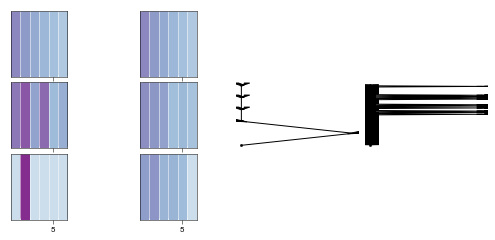

In [15]:
savetopath = ''
loadpath = ''
qax = qPlotter()

gslayout = gs(4, 4, top = 0.95, bottom =0.05, left = 0.05, right = 0.95, wspace = 0.05, hspace = 0.08)

QMAP_LIST = []
NMAP_LIST = []

for trials in range(1): #range(100):
    
    for idx_truth in range(1): 

        fig = plt.figure(figsize=(cm2inch(20),cm2inch(11)))
        LINFLAG = True
        num_qubits = num_qubits_list[idx_truth]

        GLOBALDICT["GRIDDICT"] = {}
        for idx_posy in range(num_qubits):
            if idx_posy < 10 :
                GLOBALDICT["GRIDDICT"]["QUBIT_0" + str(idx_posy)] = (0.0, float(idx_posy)*0.5)
            if idx_posy >= 10 :
                GLOBALDICT["GRIDDICT"]["QUBIT_" + str(idx_posy)] = (0.0, float(idx_posy)*0.5)


        SAMPLE_GLOBAL_MODEL = copy.deepcopy(GLOBALDICT)

        qslam = []
        truth = []
        naive = []
        controls = []

        data_key = data_key_list[idx_truth]

        for idx_msmt_iter in range(len(pick_msmt_regimes)):

            pick_regime = pick_msmt_regimes_maps[idx_msmt_iter]
            SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = ParamUpdater.meta_max_iter_scan[pick_regime]
            SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["LAMBDA_1"] = optimal_matrix[data_key -1, pick_regime, 1] 
            SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["LAMBDA_2"] = optimal_matrix[data_key -1, pick_regime, 2] 

            print "total msmts", SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["MAX_NUM_ITERATIONS"]
            print "optimal lambda pair", SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["LAMBDA_1"], SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["LAMBDA_2"]

            expt = EmpiricalRisk(SAMPLE_GLOBAL_MODEL, data_key)

            qfmap, rmap, path = expt.qslam_trial()
            nfmap, truemap = expt.naive_trial()

            dataobjs = [truemap, qfmap, nfmap]
            dataviews = ['expt', 'expt', 'expt']
            
            print         
            q_ssim = Metric.score_ssim(qfmap, truemap)
            n_ssim = Metric.score_ssim(nfmap, truemap)
            
            print " QSLAM SSIM ", q_ssim
            print "Naive SSIM", n_ssim
            
            if idx_msmt_iter == 1 :
                QMAP_LIST.append(qfmap)
                NMAP_LIST.append(nfmap)

            for idx_key in range(3):

                ax = 0.
                ax = fig.add_subplot(gslayout[idx_key, idx_msmt_iter])

                viewtype = dataviews[idx_key]

                if viewtype != 'path':
                    if viewtype != 'pred_r':
                        ax, cax = qax.show_map(ax, dataobjs[idx_key], viewtype, pickone=None, linear=LINFLAG)


                        if idx_key == 1:

                            ax1 = fig.add_subplot(gslayout[idx_key, idx_msmt_iter**2 + 2] )

                            ax1 = qax.show_control_path(ax1, path, GRIDDICT, 
                                                        viewtype='expt',
                                                        pickone=None, 
                                                        linear=LINFLAG)
                            ax1.get_yaxis().set_visible(False)
                            ax1.get_xaxis().set_visible(False)
                            for edge, spine in ax1.spines.items():
                                spine.set_visible(False)

                ax.set_aspect(7)           

        # plt.colorbar(cax, ticks=[0.0, np.pi], format='%0.2f', orientation='horizontal')
        plt.savefig('../paperfigs/'+metrictypename+str(idx_truth)+'expt_maps_v3.svg', format='svg', dpi=800)
        plt.show()
        

    